In [1]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import types
from timm.models.swin_transformer_v2 import WindowAttention

# Load the model and modify image size if needed
swin_model = timm.create_model('swinv2_tiny_window8_256', pretrained=True)
swin_model.patch_embed.img_size = (224, 224)
swin_model.patch_embed.strict_img_size = False

# Move model to device first
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
swin_model = swin_model.to(device)

# Find all WindowAttention instances in the model
for name, module in swin_model.named_modules():
    if isinstance(module, WindowAttention):
        # Add uncertainty branch to this module instance
        module.uncertainty_branch = nn.Sequential(
            nn.LayerNorm(module.dim),
            nn.Linear(module.dim, module.num_heads),
            nn.Sigmoid()
        ).to(device)  # Move to same device as model

        # Define the new forward method
        def new_forward(self, x, mask=None):
            # Call the original forward up to the softmax
            B_, N, C = x.shape
            qkv_bias = None
            if self.q_bias is not None:
                qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
            qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
            qkv = qkv.reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]

            # cosine attention
            attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))
            # FIX: Create tensor on same device as model
            max_value = torch.log(torch.tensor(1. / 0.01, device=x.device))
            logit_scale = torch.clamp(self.logit_scale, max=max_value).exp()
            attn = attn * logit_scale

            relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).view(-1, self.num_heads)
            relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
            relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
            attn = attn + relative_position_bias.unsqueeze(0)

            if mask is not None:
                nW = mask.shape[0]
                attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
                attn = attn.view(-1, self.num_heads, N, N)
                attn = self.softmax(attn)
            else:
                attn = self.softmax(attn)

            # SRA: Compute uncertainty scores and modulate attention
            uncertainty_scores = self.uncertainty_branch(x)  # (B_, N, num_heads)
            uncertainty_scores = uncertainty_scores.permute(0, 2, 1)  # (B_, num_heads, N)

            # Rescale to range [0.5, 1.5] to allow both enhancement and suppression
            uncertainty_factors = uncertainty_scores * 1.0 + 0.5

            # Reshape for broadcasting
            uncertainty_factors = uncertainty_factors.unsqueeze(-1)  # (B_, num_heads, N, 1)

            # Apply the scaling factors to attention weights
            attn = attn * uncertainty_factors

            attn = self.attn_drop(attn)

            x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
            x = self.proj(x)
            x = self.proj_drop(x)
            return x

        # Replace the forward method
        module.forward = types.MethodType(new_forward, module)

print(f"SRA enhancement applied to {swin_model.__class__.__name__} on {device}")

SRA enhancement applied to SwinTransformerV2 on cpu


In [2]:
swin_model.load_state_dict(torch.load('swin_sra_final_model.pth',map_location=torch.device('cpu')))
swin_model.eval()

/var/folders/4f/2nsm3sqn5b9_2nbs_3xv3cc80000gn/T/ipykernel_45546/3937021846.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin_model.load_state_dict(torch.load('swin_s

SwinTransformerV2(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerV2Stage(
      (downsample): Identity()
      (blocks): ModuleList(
        (0): SwinTransformerV2Block(
          (attn): WindowAttention(
            (cpb_mlp): Sequential(
              (0): Linear(in_features=2, out_features=512, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=512, out_features=3, bias=False)
            )
            (qkv): Linear(in_features=96, out_features=288, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
            (uncertainty_branch): Sequential(
              (0): LayerNorm((96,), eps=1e-05, elementwise_affine=Tr

/var/folders/4f/2nsm3sqn5b9_2nbs_3xv3cc80000gn/T/ipykernel_45546/2822018083.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin_model.load_state_dict(torch.load("swin_

Predicted: Severe (Confidence: 99.99%)


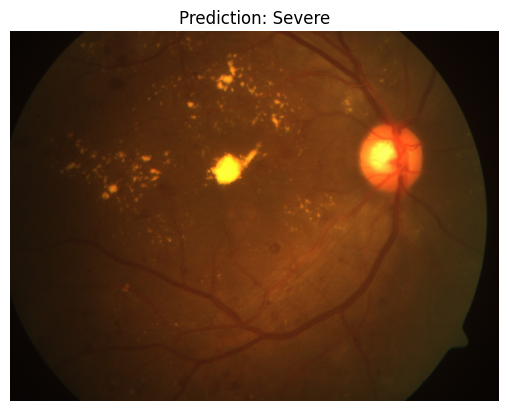

In [7]:
import torch
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the custom ImagePreprocessor class
class ImagePreprocessor:
    def __init__(self, clip_limit_l=5.0, clip_limit_ab=1.5, tile_grid_size=(8, 8), gamma_scale=1.2):
        self.clip_limit_l = clip_limit_l
        self.clip_limit_ab = clip_limit_ab
        self.tile_grid_size = tile_grid_size
        self.gamma_scale = gamma_scale
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Ensures all images are the same size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

    def apply_clahe(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe_l = cv2.createCLAHE(clipLimit=self.clip_limit_l, tileGridSize=self.tile_grid_size)
        clahe_ab = cv2.createCLAHE(clipLimit=self.clip_limit_ab, tileGridSize=self.tile_grid_size)
        l_clahe = clahe_l.apply(l)
        a_clahe = clahe_ab.apply(a)
        b_clahe = clahe_ab.apply(b)
        lab_clahe = cv2.merge((l_clahe, a_clahe, b_clahe))
        return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    def adaptive_gamma_correction(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mean_intensity = np.mean(gray) / 255.0
        gamma = np.clip(1.0 + (self.gamma_scale - 1.0) * (0.5 - mean_intensity), 0.5, 2.0) if mean_intensity > 0 else 1.0
        lookup_table = np.array([np.clip(((i / 255.0) ** gamma) * 255, 0, 255) for i in range(256)]).astype(np.uint8)
        return cv2.LUT(image, lookup_table)

    def preprocess(self, image):
        img_gamma = self.adaptive_gamma_correction(image)
        img_clahe = self.apply_clahe(img_gamma)
        img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)
        # Convert the NumPy array to a PIL Image
        img_pil = Image.fromarray(img_rgb)
        return self.transform(img_pil)


# Step 1: Load model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model.load_state_dict(torch.load("swin_sra_final_model.pth", map_location=device))
swin_model.eval()
swin_model.to(device)

# Step 2: Instantiate the preprocessor
preprocessor = ImagePreprocessor(clip_limit_l=5.0, clip_limit_ab=1.5, gamma_scale=1.2)

# Step 3: Custom preprocessing on the input image
image_path = "APTOS/train_images/0f882877bf13.png"  # Replace with your image path
image = cv2.imread(image_path)

# Preprocess the image using the ImagePreprocessor
input_tensor = preprocessor.preprocess(image).unsqueeze(0).to(device)

# Step 4: Make prediction
with torch.no_grad():
    output = swin_model(input_tensor)
    probs = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    confidence = torch.max(probs).item()

# Step 5: Print result
class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]
print(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence*100:.2f}%)")

# Optional: Show image with prediction
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Prediction: {class_names[predicted_class]}")
plt.axis('off')
plt.show()
